In [ ]:
from numpy import unique
from pandas import read_csv
from collections import Counter
from matplotlib import pyplot
from numpy import where


# **DATA READING AND DETAILS EXTRACTION STEP**



In [ ]:
# load the dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/haberman.csv'

  #  1. Age of patient at time of operation (numerical)
  #  2. Patient's year of operation (year - 1900, numerical)
  #  3. Number of positive axillary nodes detected (numerical)
  #  4. Survival status (class attribute)
  #        1 = the patient survived 5 years or longer
  #        2 = the patient died within 5 year

columns = ['Age','Operation Year','Positive Axillary Nodes','Survival status']
dataframe = read_csv(url, header=None)
dataframe.columns = columns
# get the values
values = dataframe.values

X, y = values[:, :-1], values[:, -1]
# gather details
n_rows = X.shape[0]
n_cols = X.shape[1]
classes = unique(y)
n_classes = len(classes)
counter = Counter(y)


# **DATA VISUALIZATION**





Counter({1: 225, 2: 81})


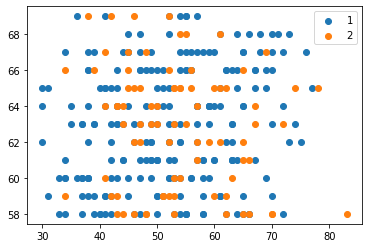

 - Class 1: 225 (73.52941%)
 - Class 2: 81 (26.47059%)


In [ ]:
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = where(y == label)[0]
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()
# class breakdown
for c in classes:
	total = len(y[y == c])
	ratio = (total / float(len(y))) * 100
	print(' - Class %s: %d (%.5f%%)' % (str(c), total, ratio))

In [ ]:
dataframe

,Age,Operation Year,Positive Axillary Nodes,Survival status
0,30,64,1,1
1,30,62,3,1
2,30,65,0,1
3,31,59,2,1
4,31,65,4,1
...,...,...,...,...
301,75,62,1,1
302,76,67,0,1
303,77,65,3,1
304,78,65,1,2


#**Implementing the IRUS Algorithm**


In [ ]:
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import clone
from sklearn.metrics import confusion_matrix
from scipy.stats import zscore, mode
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = dataframe


In [ ]:
df['Survival status'].value_counts()

1    225
2     81
Name: Survival status, dtype: int64

In [ ]:
df

,Age,Operation Year,Positive Axillary Nodes,Survival status
0,30,64,1,1
1,30,62,3,1
2,30,65,0,1
3,31,59,2,1
4,31,65,4,1
...,...,...,...,...
301,75,62,1,1
302,76,67,0,1
303,77,65,3,1
304,78,65,1,2


In [ ]:
temp_df = df.copy()
mycols = temp_df.columns

scl = MinMaxScaler()

scaled_vals = scl.fit_transform(temp_df[mycols[:-1]])

scaled_df= temp_df
scaled_df[mycols[:-1]]= scaled_vals
scaled_df[:10]

,Age,Operation Year,Positive Axillary Nodes,Survival status
0,0.000000,0.545455,0.019231,1
1,0.000000,0.363636,0.057692,1
2,0.000000,0.636364,0.000000,1
3,0.018868,0.090909,0.038462,1
4,0.018868,0.636364,0.076923,1
5,0.056604,0.000000,0.192308,1
6,0.056604,0.181818,0.000000,1
7,0.075472,0.090909,0.000000,2
8,0.075472,0.727273,0.173077,2
9,0.075472,0.000000,0.576923,1


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(scaled_df[mycols[:-1]], scaled_df[mycols[-1]],test_size=0.2)

X_train.reset_index(inplace=True)
X_test.reset_index(inplace=True)
y_train = y_train.reset_index()
y_test = y_test.reset_index()

X_train.drop(['index'], axis=1, inplace=True)
X_test.drop(['index'], axis=1, inplace=True)
y_train.drop(['index'], axis=1, inplace=True)
y_test.drop(['index'], axis=1, inplace=True)

X_train.shape, X_test.shape

((244, 3), (62, 3))

In [ ]:
kfold = RepeatedStratifiedKFold(n_splits= 5, n_repeats = 10)


In [ ]:
X_train

,Age,Operation Year,Positive Axillary Nodes
0,0.339623,0.545455,0.000000
1,0.490566,0.181818,0.000000
2,0.226415,1.000000,0.019231
3,0.660377,0.000000,0.000000
4,0.358491,0.272727,0.019231
...,...,...,...
239,0.433962,0.272727,0.019231
240,0.301887,0.000000,0.057692
241,0.018868,0.090909,0.038462
242,0.603774,0.727273,0.000000


In [ ]:
PARAMS = np.arange(0.05, 1.0, 0.05)

In [ ]:
def get_bootstrap_dataset(x_ds, y_ds, size, val):

  filt_indexes = y_ds[y_ds['Survival status']==val].index
  temp_x, temp_y = list(x_ds.iloc[filt_indexes].values), list(y_ds.iloc[filt_indexes]['Survival status'].values)
  bootstrap_x , bootstrap_y = [],[]
  for i in range(size):
    index = random.randrange(len(temp_x))
    bootstrap_x.append(temp_x[index])
    bootstrap_y.append(temp_y[index])
    temp_x.pop(index)
    temp_y.pop(index)
  return (bootstrap_x, bootstrap_y)

def get_total_dataset(x_ds, y_ds, val):
  filt_indexes = y_ds[y_ds['Survival status']==val].index
  temp_x, temp_y = list(x_ds.iloc[filt_indexes].values), list(y_ds.iloc[filt_indexes]['Survival status'].values)
  return (temp_x, temp_y)

def IRUS(Nmaj, Nmin, S, Sets, classes, train_x=None, train_y=None, val_x=None, val_y=None,  validate=True): 
  
  Dnorm = []
  model = [DecisionTreeClassifier(max_depth=3, random_state=i) for i in range(500)]
  trained_models = []
  for i in range(Sets):

    X_maj, y_maj = get_bootstrap_dataset(train_x, train_y, S, classes[0] )
    X_min, y_min = get_total_dataset(train_x, train_y, classes[1])  
    Ts_x = X_maj + X_min
    Ts_y = y_maj + y_min
    temp = list(zip(Ts_x, Ts_y))
    random.shuffle(temp)
    Ts_x,  Ts_y = zip(*temp)
    Ts_x, Ts_y = list(Ts_x), list(Ts_y)
    model[i].fit(Ts_x, Ts_y)
    if validate:
      probs = model[i].predict_proba(list(val_x.values)) # -> (n_samples in val_x, n_classes)
    else:
      probs = model[i].predict_proba(list(train_x.values)) # -> (n_samples in train_x , n_classes)
    
    D = probs[:,1]
    if (np.std(D) == 0.):
      Dnorm.append(D)
    else:
      Dnorm.append( zscore(D) )

    trained_models.append(model[i])
  
  conf_t = np.mean(Dnorm, axis=0)  # mean conf of all base models on a single val_x sample
  return conf_t, trained_models

def get_metrics(D, true_labels):

  predictions = []
  for conf in D:

    if ( conf > 0. or  (1 / (1 + np.exp(-conf))) > 0.5 ):
      predictions.append(2.)
    else:
      predictions.append(1.)
  
  tn, fp, fn, tp = confusion_matrix(true_labels, predictions).ravel()
  fpr = fp / (fp+tn)
  tpr = tp / (tp+fn)
  tnr = tn / (tn+fp)
  Gmean = np.sqrt(tpr*tnr)
  precision=  tp / (tp+fp)
  f1 = 2*precision*tpr / (precision + tpr)

  return {"fpr": fpr, "tpr":tpr, "tnr": tnr, "G-mean":Gmean, "precision": precision, "f1":f1}
  

In [ ]:
def plot_lines(bestX):
  
    """
    plotting True positive rate and false positive rate as a function of the number of
    component classifiers.
    """  
    classes = dict(y_train['Survival status'].value_counts())
    Nmaj = classes[1]
    Nmin = classes[2]
    metrics= []
    best_x= bestX
    S = int(max( 2, np.ceil(pow(Nmin, best_x) ) ))
    Sets = [i for i in range(4,100)]

    for i in range(len(Sets)):
      conf, _ = IRUS(Nmaj, Nmin, S, Sets[i], list(classes.keys()), train_x = X_train, train_y = y_train, validate=False)
      mymetrics = get_metrics(conf, y_train)
      mymetrics = list(map(mymetrics.get, ['tpr', 'fpr']))
      metrics.append(mymetrics)

    plt.figure(figsize=(10,5))
    plt.plot(Sets, np.array(metrics)[:,0], label= 'tpr')
    plt.plot(Sets, np.array(metrics)[:,1], label= 'fpr')
    plt.legend()
    plt.title('TPR & FPR as a function of component classifiers')
    plt.show()

def find_best_X():

  best_x = []
  best_x_index= []
  metrics = []
  mySets = []
  c= 1
  #performing cross validation
  for train_idx, val_idx in kfold.split(X_train, y_train): # create train-val splits
    train_x, val_x = X_train.iloc[train_idx].reset_index(), X_train.iloc[val_idx].reset_index()
    train_y, val_y = y_train.iloc[train_idx].reset_index(), y_train.iloc[val_idx].reset_index() 
    train_x.drop(['index'], axis=1, inplace=True)
    train_y.drop(['index'], axis=1, inplace=True)
    val_x.drop(['index'], axis=1, inplace=True)
    val_y.drop(['index'], axis=1, inplace=True)

    classes = dict(train_y['Survival status'].value_counts())
    Nmaj = classes[1]
    Nmin = classes[2]

    for x in PARAMS: # find the optimal value of x for every split

      # S--> controls the number of majority samples drawn at random for each model
      # Sets--> determines the number of models.

      S = int(max( 2, np.ceil(pow(Nmin, x) ) ))
      Sets = int(np.ceil(1.5 * (Nmaj / S)) )
      conf, _ = IRUS(Nmaj, Nmin, S, Sets, list(classes.keys()), train_x, train_y, val_x, val_y )
      mymetrics= get_metrics(conf, val_y)
      mymetrics = list(map(mymetrics.get, ['tpr', 'fpr']))
      metrics.append(mymetrics)

    best_x.append(max(np.array(metrics)[:,0])) # find x will best conf for that particular split
    best_x_index.append(np.argmax(np.array(metrics)[:,0]))
    metrics.clear()
    
    print("fold: ", c)
    print("bestX: ", best_x)
    print("bestX index: ", best_x_index)
    c+=1
  return best_x, best_x_index

def train(best_x):

  classes = dict(y_train['Survival status'].value_counts())
  Nmaj = classes[1]
  Nmin = classes[2]
  S = int(max( 2, np.ceil(pow(Nmin, best_x) ) ))
  Sets = int(np.ceil(1.5 * (Nmaj / S))) 

  conf, trained_models = IRUS(Nmaj, Nmin, S, Sets, list(classes.keys()), train_x = X_train, train_y = y_train, validate=False)
  metrics = get_metrics(conf, y_train)
  print("Train Metrics: ")
  print(metrics)

  return trained_models
  
def evaluate(trained_models):
  
  Dnorm = []
  for i in range(len(trained_models)):

    probs = trained_models[i].predict_proba(X_test)
    D = probs[:,1]
    Dnorm.append( zscore(D) )
  
  metrics = get_metrics(np.mean(Dnorm, axis=0), y_test)
  print("Test Metrics: ")
  print(metrics)

  return

In [ ]:
best_x, bxi = find_best_X()
bestX = PARAMS[bxi[np.argmax(best_x)]]
print("\nBest X: ", bestX)

fold:  1
bestX:  [0.8461538461538461]
bestX index:  [2]
fold:  2
bestX:  [0.8461538461538461, 0.9230769230769231]
bestX index:  [2, 1]
fold:  3
bestX:  [0.8461538461538461, 0.9230769230769231, 0.7692307692307693]
bestX index:  [2, 1, 9]
fold:  4
bestX:  [0.8461538461538461, 0.9230769230769231, 0.7692307692307693, 0.8461538461538461]
bestX index:  [2, 1, 9, 3]
fold:  5
bestX:  [0.8461538461538461, 0.9230769230769231, 0.7692307692307693, 0.8461538461538461, 0.8333333333333334]
bestX index:  [2, 1, 9, 3, 0]
fold:  6
bestX:  [0.8461538461538461, 0.9230769230769231, 0.7692307692307693, 0.8461538461538461, 0.8333333333333334, 0.7692307692307693]
bestX index:  [2, 1, 9, 3, 0, 1]
fold:  7
bestX:  [0.8461538461538461, 0.9230769230769231, 0.7692307692307693, 0.8461538461538461, 0.8333333333333334, 0.7692307692307693, 0.7692307692307693]
bestX index:  [2, 1, 9, 3, 0, 1, 4]
fold:  8
bestX:  [0.8461538461538461, 0.9230769230769231, 0.7692307692307693, 0.8461538461538461, 0.8333333333333334, 0.76923

In [ ]:
trained_models = train(bestX)

Train Metrics: 
{'fpr': 0.3333333333333333, 'tpr': 0.859375, 'tnr': 0.6666666666666666, 'G-mean': 0.7569125885243729, 'precision': 0.4782608695652174, 'f1': 0.6145251396648045}


In [ ]:
evaluate(trained_models)

Test Metrics: 
{'fpr': 0.4666666666666667, 'tpr': 0.6470588235294118, 'tnr': 0.5333333333333333, 'G-mean': 0.587450456818008, 'precision': 0.34375, 'f1': 0.4489795918367347}


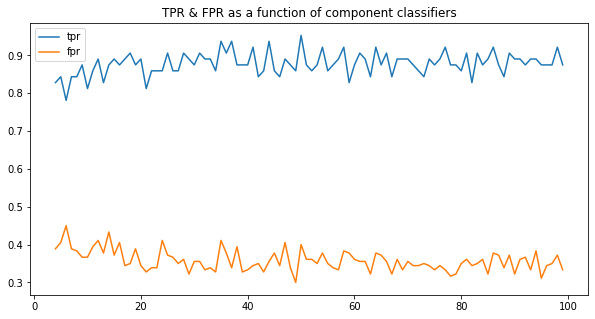

In [ ]:
plot_lines(bestX)